In [19]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from nltk.corpus import webtext
from nltk.probability import FreqDist
import re

import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob as tb
import pandas as pd
import json
from flask import jsonify
import datetime
import json
import configparser
import traceback
import os
from dotenv import load_dotenv

from wordcloud import WordCloud

import spacy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [20]:
#Load environment variables
load_dotenv()


True

In [21]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('webtext')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oluwasogo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/oluwasogo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /Users/oluwasogo/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

In [22]:

def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [23]:
def clean_texts(text):
    # remove urls
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))', '', text, flags=re.MULTILINE)
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT)", " ", text)

    text = remove_emoji(text)
    
    tokens =  word_tokenize(text.lower())
    stp_wrd = stopwords.words("english")
    stp_wrd.extend(["join", "di", "io", "thing", "sa", "co", "ph", "us", "rt", "it's", "it"])
    token_list = [token for token in tokens if token not in stp_wrd]
    return " ".join(token_list)
    

In [24]:


def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)



In [25]:
def clean_texts(text):
    # remove urls
    text = re.sub(r"http\S+", "", text)
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT)", " ", text)

    text = remove_emoji(text)
    
    tokens =  word_tokenize(text)
        stp_wrd.extend(["join", "di", "io", "thing", "sa", "co", "ph", "us", "rt", "it's", "it"])

    
    token_list = [token for token in tokens if token not in stopwords.words("english")]
    return token_list
    

In [26]:
def get_config():
    try:
        CONSUMER_KEY = os.getenv("CONSUMER_KEY")
        CONSUMER_SECRET = os.getenv("CONSUMER_SECRET")
        ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
        ACCESS_TOKEN_SECRET = os.getenv("ACCESS_TOKEN_SECRET")

        auth = tweepy.OAuthHandler(str(CONSUMER_KEY).strip(), str(CONSUMER_SECRET).strip())
        auth.set_access_token(str(ACCESS_TOKEN).strip(), str(ACCESS_TOKEN_SECRET).strip())
        api = tweepy.API(auth)
        return api
    except Exception as e:
        print(traceback.print_exc())
        os.exit()


In [27]:
def fetch_user_tweets(api, user_handle):
    tweet_list = []
    tweets = api.user_timeline(screen_name=user_handle, 
                           # 200 is the maximum allowed count
                           count=200,
                           include_rts = True,
                           # Necessary to keep full_text 
                           # otherwise only the first 140 words are extracted
                           tweet_mode = 'extended'
                           )
    for tweet in tweets:
        tweet_list.append(tweet._json["full_text"])
    return tweet_list
    

In [28]:
def filter_by_word(word, tweet_list):
    res = [ tweet_ for tweet_ in tweet_list if word.lower() in tweet_.lower()]
    return res

    

In [29]:
def get_sentiment(filtered_tweets):
    sentiments = []
    for tweet_ in filtered_tweets:
        analysis = tb(tweet_)
        polarity = analysis.sentiment.polarity
        output = 'Positive'
        if(polarity < 0):
            output = 'Negative'
        elif(0<= polarity<=0.2):
            output = 'Neutral'
            
        sentiments.append(output)
        
    pos = sentiments.count("Positive")
    neg = sentiments.count("Negative")
    neu = sentiments.count("Neutral")
    total = len(filtered_tweets)
    per_pos = round(float(pos/total* 100), 2)
    per_neg = round(float(neg/total* 100), 2 )
    per_neu = round(float(neu/total* 100), 2)
    return { "data":{
                "positive": per_pos,
                "negative":per_neg, 
                "neutral":per_neu
                },
                "status": "success"}

In [30]:
def main(user_handle, filter_word=""):
    api = get_config()
    all_tweets = fetch_user_tweets(api, user_handle)
    
    if filter_word:
        filtered_tweets = filter_by_word(filter_word, all_tweets)
    else:
        filtered_tweets = all_tweets
    if len(filtered_tweets) == 0:
        return {
            "data": {"positive": 0, "negative": 0, "neutral": 0},
            "status": "failure",
            "message": f"No response found for {filter_word}",
        }
    res = get_sentiment(filtered_tweets)
    return res


In [31]:
def plot_word_frequency():
    api = get_config()
    
    tweets = fetch_user_tweets(api, 'certikorg')
    tweets = " ".join(tweets).lower()
    tweets = clean_texts(tweets)

    
    
    freq = nltk.FreqDist(tweets)

    # Let's take the specific words only if their frequency is greater than 3.
    filter_words = dict([(m, n) for m, n in freq.items() if len(m) > 3])

    data_analysis = nltk.FreqDist(filter_words)
    wfdf = pd.DataFrame(freq.items(), columns=['token', 'frequency'])
    wfdf.head()
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    plt.title("Most used words in tweets")
    sns.barplot('frequency', 'token', data=wfdf.sort_values(by='frequency', ascending=False)[:8])
    plt.show()
    
    

    




In [32]:
def generate_word_cloud():
    api = get_config()
    tweets = fetch_user_tweets(api, 'certikorg')
    tweets = " ".join(tweets)
    cleaned_tweets = " ".join(clean_texts(tweets))
    wordcloud = WordCloud(max_font_size=75, max_words=50, background_color="white").generate(cleaned_tweets)    
    plt.figure(figsize=(10,10))
    plt.title("The most occuring words")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [33]:
USER_HANDLE = os.getenv("USER_HANDLE")
def sentiment_analysis_chart(filter_word=None):
    res = main(user_handle=USER_HANDLE, filter_word=filter_word)

    size_of_groups=[res["data"]["positive"], res["data"]["negative"], res["data"]["neutral"]]

    # Create a pieplot
    colors = sns.color_palette('dark')[0:5]
    plt.figure(figsize=(10, 10))

    plt.pie(size_of_groups, labels=["Positive", "Negative", "Neutral"],  colors = colors, autopct='%.0f%%')

    # add a circle at the center to transform it in a donut chart

    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    

    plt.show()

## Word Cloud for most occuring words in tweets


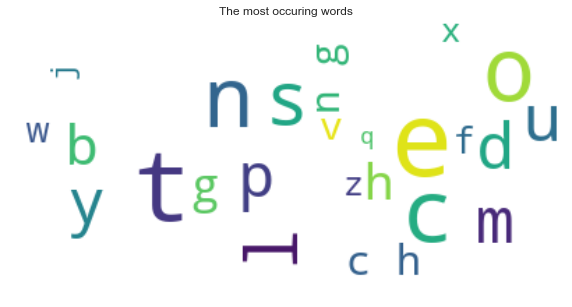

In [34]:
generate_word_cloud()

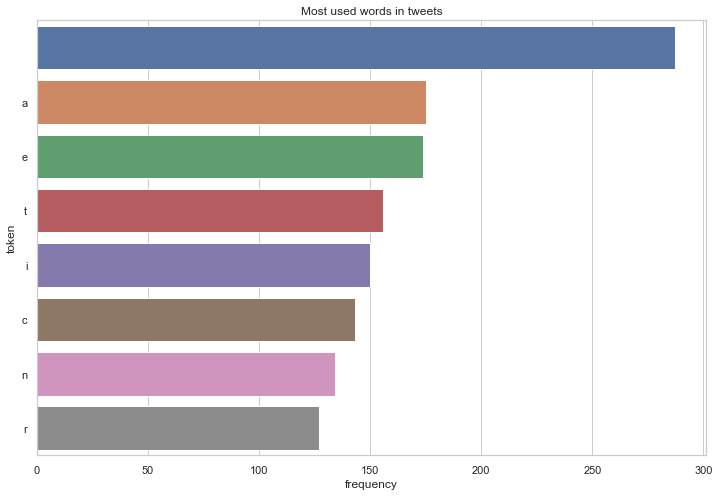

In [35]:

plot_word_frequency()


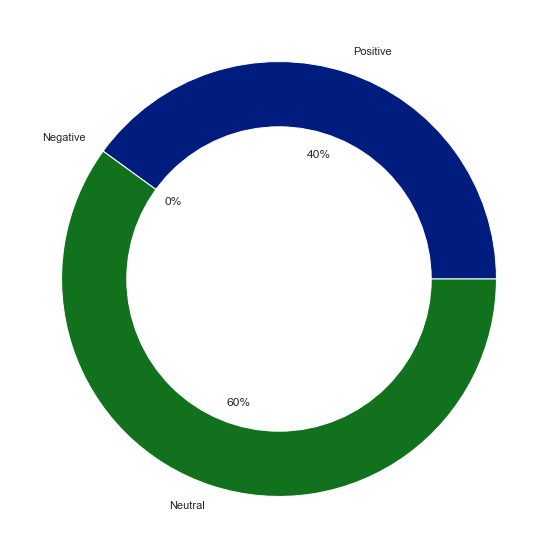

In [36]:
# using cyrpto as main word for search
sentiment_analysis_chart('crypto')